In this notebook well see how we can use the concept of graph cuts to find the MAP of a distribution described by a MRF

First lets import the necessery modules and define the dataclasses we will use:

In [124]:
from dataclasses import dataclass, field
from itertools import product
from pprint import pprint
from typing import List, Union

import numpy as np
from numpy.random import random, randn,randint
from matplotlib import pyplot as plt

import networkx as nx
from torchvision import datasets
@dataclass(frozen=True)
class NodeWithPos:
    value: float
    posx: int
    posy: int
    
    def __str__(self):
        return f'{self.posx:02d}_{self.posy:02d}'
    
    def pos(self):
        return self.posx, self.posy

@dataclass(frozen=True)
class SegmentationNode(NodeWithPos):   
    pass

@dataclass(frozen=True)
class ImageNode(NodeWithPos):
    pass
    
@dataclass(frozen=True)
class ClassNode(NodeWithPos):
    pass


def draw_graph(graph: nx.Graph, title='', ax=None):
    if ax is None:
        plt.figure()
        ax=plt.gca()
    if title:
        ax.set_title(title, color='w')
    nodelist = graph.nodes
    posdict = dict([(node, node.pos()) for node in nodelist])
    edge_witdh = [4*edge[2]['capacity'] for edge in graph.edges(data=True)]
    nx.draw_networkx_nodes(graph, posdict, nodelist, ax=ax,
                        node_color=[n.value for n in nodelist])
    nx.draw_networkx_edges(graph, posdict, graph.edges, ax=ax,
                           width=edge_witdh)
    

First let us look at a 1d example to get an intuition of how this algorithm works

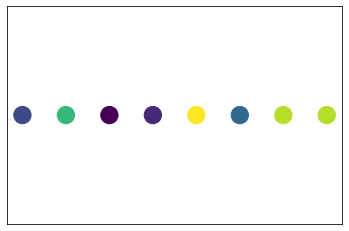

In [125]:
image_values = [0.2, 0.6, 0.0, 0.1, 0.9,0.3, 0.8, 0.8]
image_nodes = [ImageNode(c, i, 0) for i, c in enumerate(image_values)]
node_pos = dict([(node, node.pos()) for node in image_nodes])


initial_graph= nx.Graph()
initial_graph.add_nodes_from(image_nodes)
draw_graph(initial_graph)


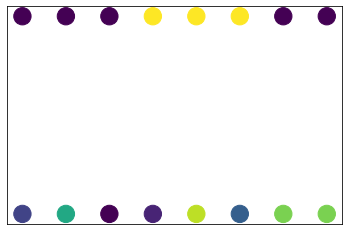

In [126]:
initial_guess = [(i//3) % 2 for i in range(len(image_values))] #000111000111...
segmentation_nodes = [SegmentationNode(guess, i, 1)
                      for i, guess in enumerate(initial_guess)]
initial_graph.add_nodes_from(segmentation_nodes)

draw_graph(initial_graph)


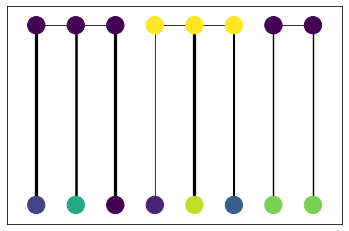

In [127]:
def similarity_energy(seg: NodeWithPos, img: NodeWithPos, limit: float = 1):
    return min((1-(seg.value - img.value)**2), limit)
    
def edge_energy(node0: NodeWithPos, node1: NodeWithPos, weight: float = 1):
    return weight if node0.value == node1.value else 0

limit = 0.8
weight = 0.2

# add energy for being close to image (vertical lines)
for img_node, seg_node in zip(image_nodes, segmentation_nodes):
    initial_graph.add_edge(seg_node, img_node,
                   capacity=similarity_energy(seg_node, img_node, limit))

# add energy for being close to neighbor (horizontal lines)
for seg1, seg2 in zip(segmentation_nodes[:-1], segmentation_nodes[1:]):
    initial_graph.add_edge(seg1, seg2,
                   capacity=edge_energy(seg1, seg2, weight))

draw_graph(initial_graph)


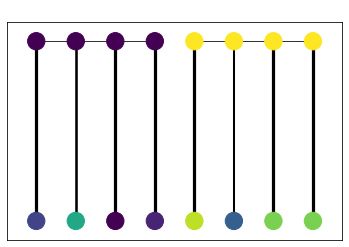

In [128]:
def brute_force_1d(img_node, weight, limit):
    best_guess = (0, None, None)
    for guess in product(*[[0,1]]*len(image_values)): #iterate over all 
        segmentation_nodes = [SegmentationNode(c, i, 1)
                            for i, c in enumerate(guess)]
        g = nx.Graph()
        for img_node, seg_node in zip(image_nodes, segmentation_nodes):
            g.add_edge(seg_node, img_node,
                        capacity=similarity_energy(seg_node, img_node, limit))
            
        for seg1, seg2 in zip(segmentation_nodes[:-1], segmentation_nodes[1:]):
            g.add_edge(seg1, seg2, capacity=edge_energy(seg1, seg2, weight))
            
        score = sum([edge[2]['capacity'] for edge in g.edges(data=True)])
        best_guess = best_guess if best_guess[0] > score else (score, guess, g)
    return best_guess

score, classes, best_graph = brute_force_1d(image_nodes, weight, limit)
draw_graph(best_graph, f'best graph given {weight=}, {limit=}')


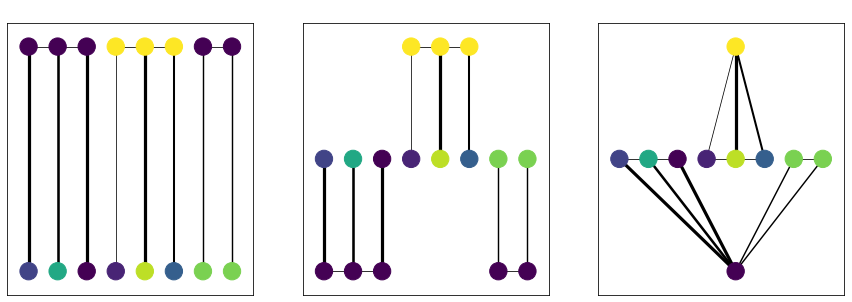

In [129]:
class_0 = ClassNode(0, len(image_nodes)/2, -1)
class_1 = ClassNode(1, len(image_nodes)/2, 1)

restructured_graph = nx.Graph()
nodes = image_nodes + [class_0, class_1]

for seg_node, img_node in zip(segmentation_nodes, image_nodes):
    class_ = class_0 if seg_node.value == 0 else class_1
    restructured_graph.add_edge(img_node, class_, 
                                capacity=similarity_energy(img_node, class_, limit))

for img0, img1, seg0, seg1 in zip(image_nodes[:-1], image_nodes[1:], 
                                  segmentation_nodes[:-1], segmentation_nodes[1:]):
    if seg0.value == seg1.value:
        restructured_graph.add_edge(
            img0, img1, capacity=weight)
        
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
repos = [SegmentationNode(guess, i, 1 if guess else -1)
                        for i, guess in enumerate(initial_guess)]
intermediate = nx.relabel_nodes(initial_graph, 
                                dict(zip(segmentation_nodes, repos)))

draw_graph(initial_graph, 'original graph', ax[0])
draw_graph(intermediate, 'original graph, but repositioned', ax[1])
draw_graph(restructured_graph, 'reformulated graph with same edge sum', ax[2])


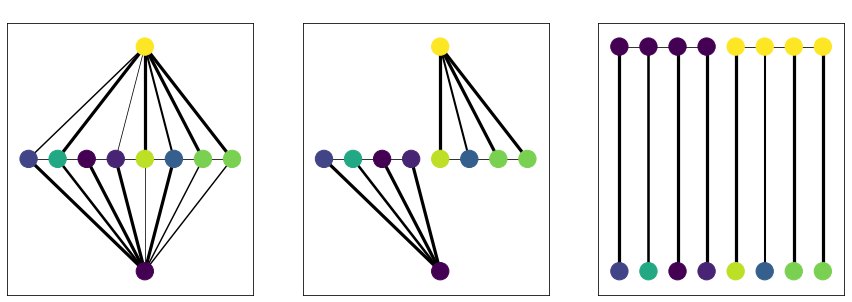

In [130]:
graph_to_cut = nx.Graph()
for seg_node, img_node in zip(segmentation_nodes, image_nodes):
    graph_to_cut.add_edge(img_node, class_0,
                                capacity=similarity_energy(img_node, class_0, limit))
    graph_to_cut.add_edge(img_node, class_1,
                                capacity=similarity_energy(img_node, class_1, limit))
    
for img0, img1 in zip(image_nodes[:-1], image_nodes[1:]):
    graph_to_cut.add_edge(img0, img1, capacity=weight)    

flow, (g0, g1) = nx.minimum_cut(graph_to_cut, class_0, class_1)
optimized_graph = graph_to_cut.copy()
toremove = [e for e in optimized_graph.edges 
            if not (e[0] in g0) ^ (e[1] in g1)]
optimized_graph.remove_edges_from(toremove)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
draw_graph(graph_to_cut, 'graph to cut',ax=ax[0])
draw_graph(optimized_graph, 'graph to cut',ax=ax[1])
draw_graph(best_graph, 'previous representation of optimal graph',ax=ax[2])

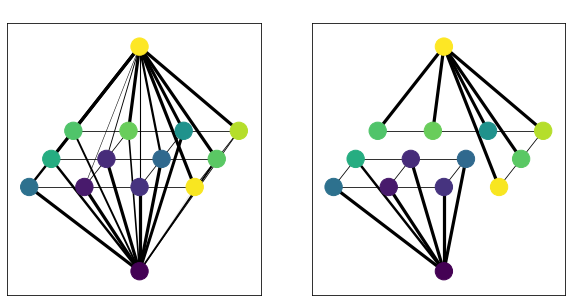

In [131]:
img = np.array([0,1,1,0,0,1,0,0,1,1,1,1]).reshape(4,3)
img = img/2 + random(img.shape)*0.5

class_0_2d = ClassNode(0, (img.shape[0])/2, -3)
class_1_2d = ClassNode(1, img.shape[0]/2, img.shape[1]+2)

nodes_2d = np.array([ImageNode(value, *np.array([[1., 0.4], [0, 1]])@idx)
                      for idx, value in zip(np.ndindex(img.shape), img.ravel())
                      ]).reshape(img.shape)
graph_2d = nx.Graph()
for node in nodes_2d.ravel():
    graph_2d.add_edge(node, class_0_2d,
                      capacity=similarity_energy(node, class_0_2d, limit))
    graph_2d.add_edge(node, class_1_2d,
                      capacity=similarity_energy(node, class_1_2d, limit))

for i, j in np.ndindex(img[:-1, :].shape):
    graph_2d.add_edge(nodes_2d[i, j], nodes_2d[i+1, j], capacity=weight)

for i, j in np.ndindex(img[:, :-1].shape):
    graph_2d.add_edge(nodes_2d[i, j], nodes_2d[i, j+1], capacity=weight)
    
flow, (g0, g1) = nx.minimum_cut(graph_2d, class_0_2d, class_1_2d)

optimized_graph_2d = graph_2d.copy()
toremove = [e for e in optimized_graph_2d.edges
            if not (e[0] in g0) ^ (e[1] in g1)]
optimized_graph_2d.remove_edges_from(toremove)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_graph(graph_2d, 'graph to cut',ax=ax[0])
draw_graph(optimized_graph_2d, 'segmented graph', ax=ax[1])


In [165]:
def segment_image(img, weight, limit):
    class_0 = ClassNode(0, None, None)
    class_1 = ClassNode(1, None, None)
    nodes = np.array([ImageNode(v, i, j)
                      for v, (i, j) in zip(img.ravel(), np.ndindex(img.shape))
                     ]).reshape(img.shape)
    graph = nx.Graph()
    for node in nodes.ravel():
        graph.add_edge(node, class_0,
                       capacity=similarity_energy(node, class_0, limit))
        graph.add_edge(node, class_1,
                       capacity=similarity_energy(node, class_1, limit))

    for i, j in np.ndindex(img[:-1, :].shape):
        graph.add_edge(nodes[i, j], nodes[i+1, j], capacity=weight)

    for i, j in np.ndindex(img[:, :-1].shape):
        graph.add_edge(nodes[i, j], nodes[i, j+1], capacity=weight)

    flow, (g0, g1) = nx.minimum_cut(graph, class_0, class_1)

    output = np.zeros_like(img)
    for node in g1:
        if isinstance(node, ImageNode):
            output[node.pos()]=1
        
    return output

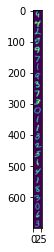

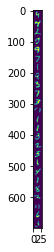

In [173]:
dataset = datasets.MNIST('data', train=False, download=True)
img = np.array(dataset[0][0])/255
img_large = np.block([[np.array(dataset[randint(0, len(dataset))][0])/255
                       for j in range(5)]
                       for i in range(5)])
segmented = segment_image(img_large, 0.2, 0.6)
plt.imshow(img_large)
plt.figure()
plt.imshow(segmented)


In [134]:
random((2,2))[(1,1)]

0.8660341652622913

In [138]:
segmented

array([[255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
        255., 255., 255., 255., 255., 255.],
       [255., 255., 255., 255., 255